In [1]:
import edward as ed
from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import helper_func
import math
import models
import scipy.special as sp
from scipy.misc import logsumexp
import gc

In [2]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

In [3]:
dataset = 'bibx' 
full_X1,x1,test_mask1 = helper_func.load_data(dataset)
dataset = 'biby' 
full_X2,x2,test_mask2 = helper_func.load_data(dataset)
result_folder = "dual_bibtex"
metric = 'mae'
users = x1.shape[0]
items1 = x1.shape[1]
items2 = x2.shape[1]
train_non_zero_indices1 = helper_func.non_zero_entries(x1)
train_non_zero_indices2 = helper_func.non_zero_entries(x2)
score = []

In [4]:
epochs = 50000
epochs += 1
test_every = 1000
no_samples_mle = 5000
no_sample_inf = 20
k = 10
param1 = models.poisson_response(users,items1);  # 'ztp' or 'normal'
param2 = models.poisson_response(users,items2);

In [5]:
varpi = 0.1 #looks like 'w^bar' or omega bar
sparsity1 = 1.0 - float(len(train_non_zero_indices1))/(users*items1)
em1 = -np.log(sparsity1)
emsq1 = np.sqrt(em1/k)
sparsity2 = 1.0 - float(len(train_non_zero_indices2))/(users*items2)
em2 = -np.log(sparsity2)
emsq2 = np.sqrt(em2/k)

varrho = 0.1 # looks like mirror inverted eta1 = varrho * emsq1  #looks like n
zeta1 = varpi *emsq1 #looks like mirror inverted cq
rho =  varrho * varrho  #looks like p
omega = varpi * varpi #looks like w

emsq = 1.0 - (float(len(train_non_zero_indices1)) + float(len(train_non_zero_indices2)))/((users*items1)+(users*items2))
emsq = -np.log(emsq)
emsq = np.sqrt(emsq/k)

eta = varrho * emsq  #looks like n

zeta1 = varpi *emsq1 #looks like mirror inverted c
zeta2 = varpi *emsq2 #looks like mirror inverted c

xi = 0.7
tau = 10000.0
n_trunc = 20;

In [6]:
t_user = np.ones(shape=users)*tau
t_item1 = np.ones(shape=items1)*tau
t_item2 = np.ones(shape=items2)*tau

a_s = np.ones(shape=[users,k])*eta
bs = np.ones(shape=[users,k])*varrho
ar =  np.ones(shape=users)*(rho+k*eta)   # not fixed in the original code
br = np.ones(shape=users)*(rho/varrho)

av1 = np.ones(shape=[items1,k])*zeta1
bv1 = np.ones(shape=[items1,k])*varpi
aw1 = np.ones(shape=items1)*(omega+k*zeta1)  # not fixed in the original code
bw1 = np.ones(shape=items1)*(omega/varpi)

av2 = np.ones(shape=[items2,k])*zeta2
bv2 = np.ones(shape=[items2,k])*varpi
aw2 = np.ones(shape=items2)*(omega+k*zeta2)  # not fixed in the original code
bw2 = np.ones(shape=items2)*(omega/varpi)

varphi = np.zeros(k)


In [7]:
# curr_loglik = cutoff_loglik -1.0users,items1,

# while cutoff_loglik > curr_loglik:
#     n_trunc -= 1
#     curr_loglik = n_trunc* np.log(em) - np.log(np.expm1(em)) - math.lgamma(n_trunc + 1);
# n_trunc += 1
# print n_trunc

In [8]:
param1.mle_update(train_non_zero_indices1,x1,no_samples_mle)
param2.mle_update(train_non_zero_indices2,x2,no_samples_mle)
del train_non_zero_indices1
del train_non_zero_indices2

In [9]:
print param1.get_param()
print param2.get_param()

1.0
1.0


In [10]:
curr_iter  = 0
while curr_iter <= epochs:
    curr_iter += 1
    u = np.random.randint(low=0,high=users,dtype='int64')
    i1 = np.random.randint(low=0,high=items1,dtype='int64')
    i2 = np.random.randint(low=0,high=items2,dtype='int64')
    tu = np.power(t_user[u],-xi)
    ti1 = np.power(t_item1[i1],-xi)
    ti2 = np.power(t_item2[i2],-xi)
    
    br[u] = (1.0-tu)*br[u] + tu*(rho/varrho + np.sum(a_s[u,:]/bs[u,:]))
    bs[u,:] = (1.0-tu)*bs[u,:] + tu*(ar[u]/br[u] + items1*(av1[i1,:]/bv1[i1,:]) + items2*(av2[i2,:]/bv2[i2,:]))
    
    bw1[i1] = (1.0-ti1)*bw1[i1] + ti1*(omega/varpi + np.sum(av1[i1,:]/bv1[i1,:]))
    bv1[i1,:] = (1.0-ti1)*bv1[i1,:] + ti1*(aw1[i1]/bw1[i1] + users*(a_s[u,:]/bs[u,:]))
    
    bw2[i2] = (1.0-ti2)*bw2[i2] + ti2*(omega/varpi + np.sum(av2[i2,:]/bv2[i2,:]))
    bv2[i2,:] = (1.0-ti2)*bv2[i2,:] + ti2*(aw2[i2]/bw2[i2] + users*(a_s[u,:]/bs[u,:]))
    
    if x1[u,i1]==0:
        av1[i1,:] = (1.0-ti1)*av1[i1,:] + ti1*zeta1
        a_s_i1 = 0.0
    else:
        A_ui1 = np.sum((a_s[u,:]*av1[i1,:])/(bs[u,:]*bv1[i1,:]))
        en1 = param1.expectation(x1[u,i1],A_ui1,n_trunc)
        varphi[:]= sp.digamma(a_s[u,:])-np.log(bs[u,:])+sp.digamma(av1[i1,:])-np.log(bv1[i1,:])
        log_norm = logsumexp(varphi[:])
        varphi[:] = np.exp(varphi[:]-log_norm)
        av1[i1,:] = (1.0-ti1)*av1[i1,:] + ti1*(zeta1+users*en1*varphi[:])
        a_s_i1 = items1*en1*varphi[:]
        
    if x2[u,i2]==0:
        av2[i2,:] = (1.0-ti2)*av2[i2,:] + ti2*zeta2
        a_s_i2 = 0.0
    else:
        A_ui2 = np.sum((a_s[u,:]*av2[i2,:])/(bs[u,:]*bv2[i2,:]))
        en2 = param2.expectation(x2[u,i2],A_ui2,n_trunc)
        varphi[:]= sp.digamma(a_s[u,:])-np.log(bs[u,:])+sp.digamma(av2[i2,:])-np.log(bv2[i2,:])
        log_norm = logsumexp(varphi[:])
        varphi[:] = np.exp(varphi[:]-log_norm)
        av2[i2,:] = (1.0-ti2)*av2[i2,:] + ti2*(zeta2+users*en2*varphi[:])
        a_s_i2 = items2*en2*varphi[:]


    a_s[u,:] = (1.0-tu)*a_s[u,:] + tu*(eta + a_s_i1 + a_s_i2)

    
    t_user[u] += 1.0
    t_item1[i1] += 1.0
    t_item2[i2] += 1.0
    
    if curr_iter%test_every == 0:
        print curr_iter
        q_theta = Gamma(a_s,bs)
        q_beta1 = Gamma(np.transpose(av1),np.transpose(bv1))
        q_beta2 = Gamma(np.transpose(av2),np.transpose(bv2))
        theta_sample = q_theta.sample(no_sample_inf).eval()
        beta1_sample = q_beta1.sample(no_sample_inf).eval()
        beta2_sample = q_beta2.sample(no_sample_inf).eval()
        score.append(helper_func.check_dual(param1,param2,theta_sample,beta1_sample,beta2_sample,\
                                            test_mask1,test_mask2,full_X1,full_X2,metric=metric))
        gc.collect()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


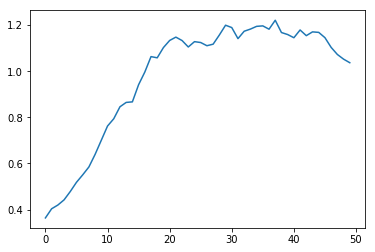

In [11]:
plt.plot(score)
plt.show()
np.savetxt('../results/'+result_folder+'/'+'hcpf_po_dual_'+metric+'_'+str(k)+'.txt',np.array(score))
